In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/07 00:33:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load Dataset
file = 'HeartDataOL.csv'
df = spark.read.csv(file, header=True, inferSchema=True)

In [7]:
selected_columns = ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio', 'gender']
data_selected = df.select(selected_columns)
missing_values = {col: data_selected.filter(data_selected[col].isNull()).count() for col in selected_columns}
print(missing_values)

{'id': 0, 'age': 1, 'height': 0, 'weight': 1, 'ap_hi': 4, 'ap_lo': 4, 'cholesterol': 4, 'glucose': 4, 'smoke': 7, 'alcohol': 8, 'active': 3, 'cardio': 3, 'gender': 0}


In [8]:
from pyspark.sql.functions import count, when, col

def count_outliers(df, column):
    # Compute Q1, Q3, and IQR
    Q1, Q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1

    # Filter rows that are considered outliers
    outliers = df.filter((pyspark.sql.functions.col(column) < (Q1 - 1.5 * IQR)) | (pyspark.sql.functions.col(column) > (Q3 + 1.5 * IQR)))
    
    return outliers.count()

def count_extremes(df, column):
    # Compute Q1, Q3, and IQR
    Q1, Q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1

    # Filter rows that are considered extremes
    extremes = df.filter((pyspark.sql.functions.col(column) < (Q1 - 3 * IQR)) | (pyspark.sql.functions.col(column) > (Q3 + 3 * IQR)))
    
    return extremes.count()

# Report on Outliers and Extremes in the selected data
print("Before cleaning:")
for col in selected_columns:
    print(f"{col} has {count_outliers(data_selected, col)} outliers.")
    print(f"{col} has {count_extremes(data_selected, col)} extreme values.")
print("\n---\n")

# Check for missing values
missing_values = data_selected.select([count(when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in selected_columns])
missing_values.show()

Before cleaning:
id has 0 outliers.
id has 0 extreme values.
age has 15 outliers.
age has 11 extreme values.
height has 528 outliers.
height has 102 extreme values.
weight has 1825 outliers.
weight has 176 extreme values.
ap_hi has 1437 outliers.
ap_hi has 291 extreme values.
ap_lo has 4635 outliers.
ap_lo has 1139 extreme values.
cholesterol has 17615 outliers.
cholesterol has 17615 extreme values.
glucose has 10521 outliers.
glucose has 10521 extreme values.
smoke has 6169 outliers.
smoke has 6169 extreme values.
alcohol has 3764 outliers.
alcohol has 3764 extreme values.
active has 13736 outliers.
active has 13736 extreme values.
cardio has 0 outliers.
cardio has 0 extreme values.
gender has 0 outliers.
gender has 0 extreme values.

---

+---+---+------+------+-----+-----+-----------+-------+-----+-------+------+------+------+
| id|age|height|weight|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|gender|
+---+---+------+------+-----+-----+-----------+-------+-----+------

In [9]:
from pyspark.sql.functions import *

# Removing unrealistic or erroneous data for age, height, weight, and blood pressures
data_clean = df.filter(
    (col('age') >= 18) & (col('age') <= 110) &
    (col('height') >= 130) & (col('height') <= 220) &
    (col('weight') >= 40) & (col('weight') <= 180) &
    (col('ap_hi') > 0) & (col('ap_hi') < 250) &
    (col('ap_lo') > 0) & (col('ap_lo') < 150)
)

# Ensuring binary columns contain only 0 or 1
binary_cols = ['smoke', 'alcohol', 'active', 'cardio']
for b_col in binary_cols:
    data_clean = data_clean.filter(col(b_col).isin([0, 1]))

# Ensuring 'cholesterol' and 'glucose' only contain values 1, 2, and 3, and removing other rows
category_cols = ['cholesterol', 'glucose']
for c_col in category_cols:
    data_clean = data_clean.filter(col(c_col).isin([1, 2, 3]))

# Replace outliers with median for height
height_median = data_clean.approxQuantile('height', [0.5], 0.01)[0]
Q1, Q3 = data_clean.approxQuantile('height', [0.25, 0.75], 0.01)
IQR = Q3 - Q1

data_clean = data_clean.withColumn(
    'height',
    when((col('height') < (Q1 - 1.5 * IQR)) | (col('height') > (Q3 + 1.5 * IQR)), height_median).otherwise(col('height'))
)

# Outlier and extreme values reporting
print("After 1st cleaning:")
for col in df.columns:
    print(f"{col} has {count_outliers(data_clean, col)} outliers.")
    print(f"{col} has {count_extremes(data_clean, col)} extreme values.")
print("\n---\n")

# For missing values
missing_values_after_cleaning = data_clean.select([count(when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values_after_cleaning.show()

After 1st cleaning:
id has 0 outliers.
id has 0 extreme values.
age has 4 outliers.
age has 0 extreme values.
gender has 0 outliers.
gender has 0 extreme values.
height has 367 outliers.
height has 0 extreme values.
weight has 1688 outliers.
weight has 150 extreme values.
ap_hi has 1229 outliers.
ap_hi has 221 extreme values.
ap_lo has 3600 outliers.
ap_lo has 130 extreme values.
cholesterol has 17193 outliers.
cholesterol has 17193 extreme values.
glucose has 10302 outliers.
glucose has 10302 extreme values.
smoke has 6047 outliers.
smoke has 6047 extreme values.
alcohol has 3684 outliers.
alcohol has 3684 extreme values.
active has 13516 outliers.
active has 13516 extreme values.
cardio has 0 outliers.
cardio has 0 extreme values.

---

+---+---+------+------+------+-----+-----+-----------+-------+-----+-------+------+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|
+---+---+------+------+------+-----+-----+-----------+-------+-----+-

In [10]:
from pyspark.sql.functions import when

def replace_outliers_with_median(df, column):
    # Compute Q1, Q3, IQR, and median
    Q1, Q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1
    median_val = df.approxQuantile(column, [0.5], 0.01)[0]

    # Replace values that are considered outliers with the median
    return df.withColumn(column, when((pyspark.sql.functions.col(column) < (Q1 - 1.5 * IQR)) | (pyspark.sql.functions.col(column) > (Q3 + 1.5 * IQR)), median_val).otherwise(pyspark.sql.functions.col(column)))

# Apply the function
for col in ['weight', 'ap_hi', 'ap_lo', 'age']:
    data_clean = replace_outliers_with_median(data_clean, col)

# Checking again for outliers and extremes
print("After handling outliers, 2nd cleaning:")
for col in data_clean.columns:
    print(f"{col} has {count_outliers(data_clean, col)} outliers.")
    print(f"{col} has {count_extremes(data_clean, col)} extreme values.")

After handling outliers, 2nd cleaning:
id has 0 outliers.
id has 0 extreme values.
age has 0 outliers.
age has 0 extreme values.
gender has 0 outliers.
gender has 0 extreme values.
height has 367 outliers.
height has 0 extreme values.
weight has 1141 outliers.
weight has 0 extreme values.
ap_hi has 0 outliers.
ap_hi has 0 extreme values.
ap_lo has 0 outliers.
ap_lo has 0 extreme values.
cholesterol has 17193 outliers.
cholesterol has 17193 extreme values.
glucose has 10302 outliers.
glucose has 10302 extreme values.
smoke has 6047 outliers.
smoke has 6047 extreme values.
alcohol has 3684 outliers.
alcohol has 3684 extreme values.
active has 13516 outliers.
active has 13516 extreme values.
cardio has 0 outliers.
cardio has 0 extreme values.


In [11]:
from pyspark.sql.functions import when, lit

# For the height outlier handling, calculate IQR first.
Q1_height, Q3_height = data_clean.approxQuantile("height", [0.25, 0.75], 0.01)
IQR_height = Q3_height - Q1_height
median_height = data_clean.approxQuantile("height", [0.5], 0.01)[0]

# Replace height outliers with median
data_clean = data_clean.withColumn("height", when((pyspark.sql.functions.col("height") < (Q1_height - 1.5 * IQR_height)) | 
                                                  (pyspark.sql.functions.col("height") > (Q3_height + 1.5 * IQR_height)), 
                                                  median_height).otherwise(pyspark.sql.functions.col("height")))

# Handle categorical and binary fields with outliers
categorical_dict = {
    "cholesterol": [1, 2, 3],
    "glucose": [1, 2, 3],
    "smoke": [0, 1],
    "alcohol": [0, 1],
    "active": [0, 1]
}

for column, valid_values in categorical_dict.items():
    mode_val = data_clean.groupBy(column).count().orderBy("count", ascending=False).limit(1).select(column).collect()[0][0]
    data_clean = data_clean.withColumn(column, when(pyspark.sql.functions.col(column).isin(valid_values), pyspark.sql.functions.col(column)).otherwise(lit(mode_val)))

# Checking again for outliers and extremes after the third cleaning
print("After handling outliers, 3rd cleaning:")
for column in data_clean.columns:
    print(f"{column} has {count_outliers(data_clean, column)} outliers.")
    print(f"{column} has {count_extremes(data_clean, column)} extreme values.")


After handling outliers, 3rd cleaning:
id has 0 outliers.
id has 0 extreme values.
age has 0 outliers.
age has 0 extreme values.
gender has 0 outliers.
gender has 0 extreme values.
height has 0 outliers.
height has 0 extreme values.
weight has 1141 outliers.
weight has 0 extreme values.
ap_hi has 0 outliers.
ap_hi has 0 extreme values.
ap_lo has 0 outliers.
ap_lo has 0 extreme values.
cholesterol has 17193 outliers.
cholesterol has 17193 extreme values.
glucose has 10302 outliers.
glucose has 10302 extreme values.
smoke has 6047 outliers.
smoke has 6047 extreme values.
alcohol has 3684 outliers.
alcohol has 3684 extreme values.
active has 13516 outliers.
active has 13516 extreme values.
cardio has 0 outliers.
cardio has 0 extreme values.


In [12]:
from pyspark.sql.functions import max, min

# Count the number of rows
print(f"Number of Rows Left After Data Cleaning: {data_clean.count()}")

# Save the cleaned DataFrame to CSV
data_clean.write.csv("output_data.csv", header=True, mode="overwrite")

# Print max and min values for each column
for column in data_clean.columns:
    max_val = data_clean.agg(max(column)).collect()[0][0]
    min_val = data_clean.agg(min(column)).collect()[0][0]
    print(f"Column: {column}")
    print(f"Max value: {max_val}")
    print(f"Min value: {min_val}")
    print("-" * 40)

Number of Rows Left After Data Cleaning: 68742


Column: id
Max value: 69999
Min value: 1
----------------------------------------
Column: age
Max value: 65.0
Min value: 39.0
----------------------------------------
Column: gender
Max value: 1
Min value: 0
----------------------------------------
Column: height
Max value: 184.0
Min value: 144.0
----------------------------------------
Column: weight
Max value: 107.0
Min value: 40.0
----------------------------------------
Column: ap_hi
Max value: 170.0
Min value: 90.0
----------------------------------------
Column: ap_lo
Max value: 105.0
Min value: 65.0
----------------------------------------
Column: cholesterol
Max value: 3
Min value: 1
----------------------------------------
Column: glucose
Max value: 3
Min value: 1
----------------------------------------
Column: smoke
Max value: 1
Min value: 0
----------------------------------------
Column: alcohol
Max value: 1
Min value: 0
----------------------------------------
Column: active
Max value: 1
Min value: 0
---------------------

In [13]:
from pyspark.sql.functions import round

# Create a copy of df1 as dfc
dfc = data_clean

# Print the count of rows
print(f"Number of Rows: {dfc.count()}")

# Create a new column BMI in the dfc DataFrame
dfc = dfc.withColumn("BMI", round(dfc["weight"] / (dfc["height"] / 100)**2, 3))

# Display the first 10 rows of the DataFrame
dfc.show(10)

# Save the dfc DataFrame to a CSV file
dfc.write.csv("output_data3.3.csv", header=True, mode="overwrite")

from pyspark.sql.functions import round, col

# Rounding values to 2 decimal places (for select columns)
rounded_desc = dfc.select(df.columns).describe()
for col_name in rounded_desc.columns[1:]:  # skip the summary column
    rounded_desc = rounded_desc.withColumn(col_name, round(col(col_name), 2))
rounded_desc.show()


Number of Rows: 68742
+---+----+------+------+------+-----+-----+-----------+-------+-----+-------+------+------+------+
| id| age|gender|height|weight|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|   BMI|
+---+----+------+------+------+-----+-----+-----------+-------+-----+-------+------+------+------+
|  1|55.0|     1| 156.0|  85.0|140.0| 90.0|          3|      1|    0|      0|     1|     1|34.928|
|  2|52.0|     1| 165.0|  64.0|130.0| 70.0|          3|      1|    0|      0|     0|     1|23.508|
|  3|48.0|     0| 169.0|  82.0|150.0|100.0|          1|      1|    0|      0|     1|     1| 28.71|
|  4|48.0|     1| 156.0|  56.0|100.0| 80.0|          1|      1|    0|      0|     0|     0|23.011|
|  5|60.0|     1| 151.0|  67.0|120.0| 80.0|          2|      2|    0|      0|     0|     0|29.385|
|  7|62.0|     0| 178.0|  95.0|130.0| 90.0|          3|      3|    0|      0|     1|     1|29.984|
|  8|48.0|     1| 158.0|  71.0|110.0| 70.0|          1|      1|    0|      0|     1|   

+-------+--------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|summary|      id|    age| gender| height| weight|  ap_hi|  ap_lo|cholesterol|glucose|  smoke|alcohol| active| cardio|
+-------+--------+-------+-------+-------+-------+-------+-------+-----------+-------+-------+-------+-------+-------+
|  count| 68742.0|68742.0|68742.0|68742.0|68742.0|68742.0|68742.0|    68742.0|68742.0|68742.0|68742.0|68742.0|68742.0|
|   mean|35028.01|  53.33|   0.65| 164.33|  72.99| 125.81|  81.83|       1.36|   1.23|   0.09|   0.05|    0.8|   0.49|
| stddev|20185.89|   6.77|   0.48|   7.42|  12.26|  15.08|   7.63|       0.68|   0.57|   0.28|   0.23|    0.4|    0.5|
|    min|     1.0|   39.0|    0.0|  144.0|   40.0|   90.0|   65.0|        1.0|    1.0|    0.0|    0.0|    0.0|    0.0|
|    max| 69999.0|   65.0|    1.0|  184.0|  107.0|  170.0|  105.0|        3.0|    3.0|    1.0|    1.0|    1.0|    1.0|
+-------+--------+-------+-------+-------+------

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType

# Initialize Spark session
spark = SparkSession.builder.appName('merge_data').getOrCreate()

# 1. Drop the 'gender' column from dfc
dmerge = dfc.drop('gender')

# 2. Save the cleaned data (skip if you don't want to save to intermediate file)
dmerge.write.csv("output_data3.4_spark.csv", header=True, mode="overwrite")

# 3. Read the saved cleaned data and the external dataset
d1 = spark.read.csv("output_data3.4_spark.csv", header=True, inferSchema=True)
d2 = spark.read.csv("HeartData3.csv", header=True, inferSchema=True)

# 4. Ensure the 'id' columns in both datasets have the same datatype
d1 = d1.withColumn("id", d1["id"].cast(IntegerType()))
d2 = d2.withColumn("id", d2["id"].cast(IntegerType()))

# 5. Merge the dataframes based on a common column 'id'
merged_df = d1.join(d2, on="id", how="inner")

# 6. Save the merged dataframe to a new CSV
merged_df.write.csv("merged_file_spark.csv", header=True, mode="overwrite")

# 7. Print the info of the merged dataframe
merged_df.printSchema()

merged_df.show(10)


root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alcohol: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- gender: integer (nullable = true)

+---+----+------+------+-----+-----+-----------+-------+-----+-------+------+------+------+------+
| id| age|height|weight|ap_hi|ap_lo|cholesterol|glucose|smoke|alcohol|active|cardio|   BMI|gender|
+---+----+------+------+-----+-----+-----------+-------+-----+-------+------+------+------+------+
|  1|55.0| 156.0|  85.0|140.0| 90.0|          3|      1|    0|      0|     1|     1|34.928|     0|
|  2|52.0| 165.0|  64.0|130.0| 70.0|          3|      1|    0|  

In [25]:
from pyspark.sql import SparkSession
import os

# Initialize Spark session
spark = SparkSession.builder.appName('csv_to_json').getOrCreate()

# Step 1: Read the CSV file
df = spark.read.csv('output_data3.3.csv', header=True, inferSchema=True)

# Step 2: Save the dataframe to a JSON directory
output_path = 'output_data3.3.json'
df.write.mode('overwrite').json(output_path)  # Note the mode('overwrite')

print("Data has been successfully converted and saved.")

# List all the files inside the directory
json_files = os.listdir(output_path)

# To display the first few lines of the first JSON file (for verification purposes)
with open(os.path.join(output_path, json_files[0]), 'r') as file:
    for _ in range(5):  # Let's display first 5 lines as an example
        print(file.readline())


Data has been successfully converted and saved.
{"id":1,"age":55.0,"gender":1,"height":156.0,"weight":85.0,"ap_hi":140.0,"ap_lo":90.0,"cholesterol":3,"glucose":1,"smoke":0,"alcohol":0,"active":1,"cardio":1,"BMI":34.928}

{"id":2,"age":52.0,"gender":1,"height":165.0,"weight":64.0,"ap_hi":130.0,"ap_lo":70.0,"cholesterol":3,"glucose":1,"smoke":0,"alcohol":0,"active":0,"cardio":1,"BMI":23.508}

{"id":3,"age":48.0,"gender":0,"height":169.0,"weight":82.0,"ap_hi":150.0,"ap_lo":100.0,"cholesterol":1,"glucose":1,"smoke":0,"alcohol":0,"active":1,"cardio":1,"BMI":28.71}

{"id":4,"age":48.0,"gender":1,"height":156.0,"weight":56.0,"ap_hi":100.0,"ap_lo":80.0,"cholesterol":1,"glucose":1,"smoke":0,"alcohol":0,"active":0,"cardio":0,"BMI":23.011}

{"id":5,"age":60.0,"gender":1,"height":151.0,"weight":67.0,"ap_hi":120.0,"ap_lo":80.0,"cholesterol":2,"glucose":2,"smoke":0,"alcohol":0,"active":0,"cardio":0,"BMI":29.385}



In [28]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('category_conversion').getOrCreate()

# Use StringIndexer to convert the columns to category type
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfc) for column in ["cholesterol", "glucose"]]

# Apply the transformation
for indexer in indexers:
    dfc = indexer.transform(dfc).drop(indexer.getInputCol())

# Rename the new columns back to original names
dfc = dfc.withColumnRenamed("cholesterol_index", "cholesterol").withColumnRenamed("glucose_index", "glucose")

# Show transformed dataframe
dfc.show(10)


# Assuming dfc is your DataFrame
dfc.printSchema()

+---+----+------+------+------+-----+-----+-----+-------+------+------+------+-----------+-------+
| id| age|gender|height|weight|ap_hi|ap_lo|smoke|alcohol|active|cardio|   BMI|cholesterol|glucose|
+---+----+------+------+------+-----+-----+-----+-------+------+------+------+-----------+-------+
|  1|55.0|     1| 156.0|  85.0|140.0| 90.0|    0|      0|     1|     1|34.928|        2.0|    0.0|
|  2|52.0|     1| 165.0|  64.0|130.0| 70.0|    0|      0|     0|     1|23.508|        2.0|    0.0|
|  3|48.0|     0| 169.0|  82.0|150.0|100.0|    0|      0|     1|     1| 28.71|        0.0|    0.0|
|  4|48.0|     1| 156.0|  56.0|100.0| 80.0|    0|      0|     0|     0|23.011|        0.0|    0.0|
|  5|60.0|     1| 151.0|  67.0|120.0| 80.0|    0|      0|     0|     0|29.385|        1.0|    2.0|
|  7|62.0|     0| 178.0|  95.0|130.0| 90.0|    0|      0|     1|     1|29.984|        2.0|    1.0|
|  8|48.0|     1| 158.0|  71.0|110.0| 70.0|    0|      0|     1|     0|28.441|        0.0|    0.0|
|  9|54.0|

In [32]:
from pyspark.sql.functions import col

# Convert 'cholesterol' and 'glucose' to string
dfc = dfc.withColumn("cholesterol", col("cholesterol").cast("string"))
dfc = dfc.withColumn("glucose", col("glucose").cast("string"))

# Show the schema and the data
#dfc.printSchema()
#dfc.show(10)

# Convert 'cholesterol' and 'glucose' to string
dfc = dfc.withColumn("cholesterol", col("cholesterol").cast("integer"))
dfc = dfc.withColumn("glucose", col("glucose").cast("integer"))

# Show the schema and the data
dfc.printSchema()
dfc.show(10)


root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alcohol: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- glucose: integer (nullable = true)

+---+----+------+------+------+-----+-----+-----+-------+------+------+------+-----------+-------+
| id| age|gender|height|weight|ap_hi|ap_lo|smoke|alcohol|active|cardio|   BMI|cholesterol|glucose|
+---+----+------+------+------+-----+-----+-----+-------+------+------+------+-----------+-------+
|  1|55.0|     1| 156.0|  85.0|140.0| 90.0|    0|      0|     1|     1|34.928|          2|      0|
|  2|52.0|     1| 165.0|  64.0|130.0| 70.0|    0|      0|     0|

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 07:25:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/10 07:25:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


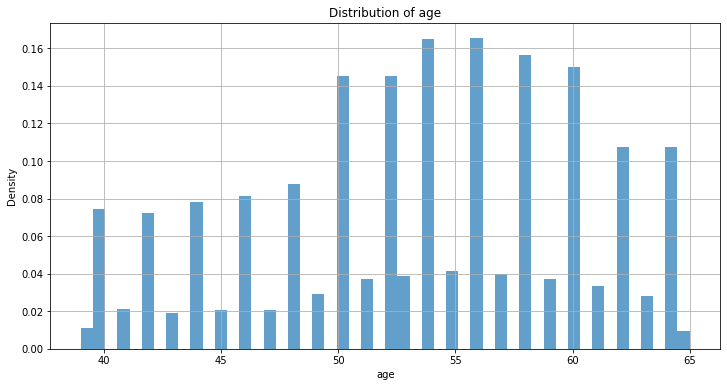

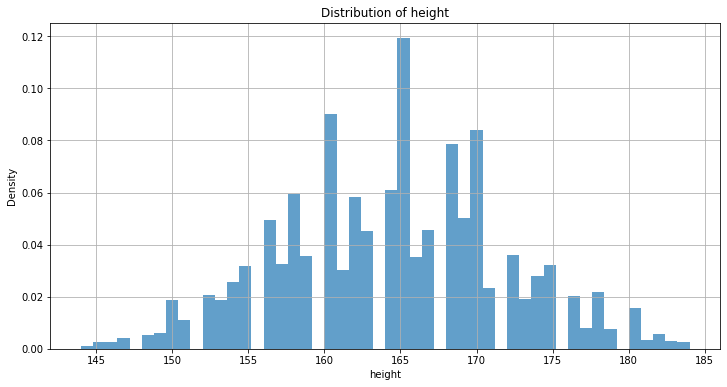

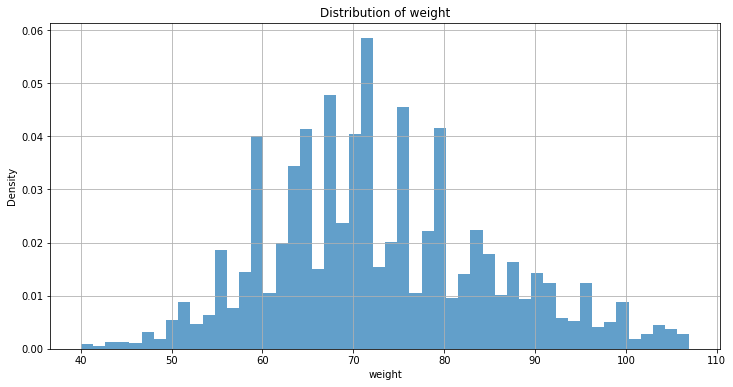

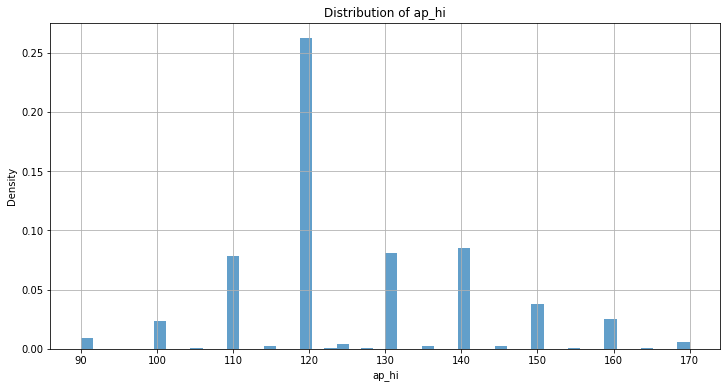

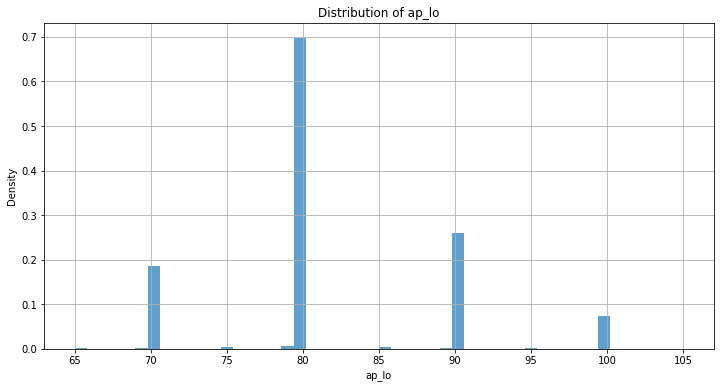

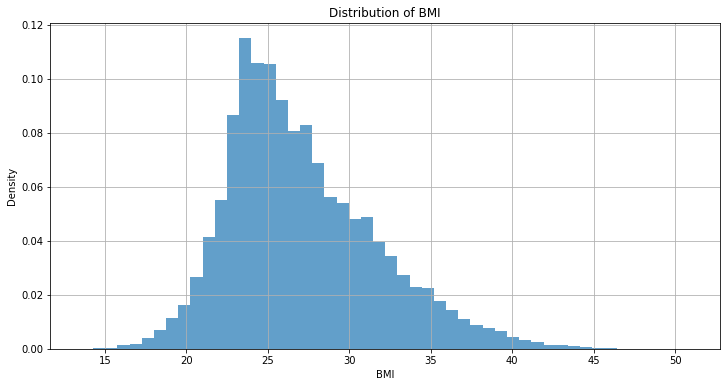

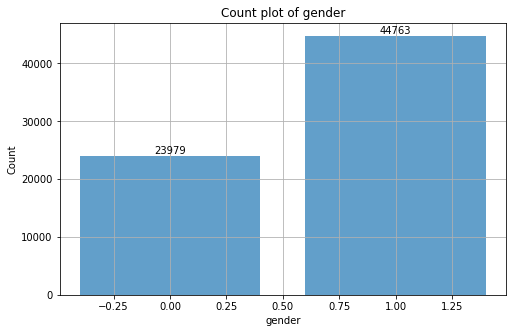

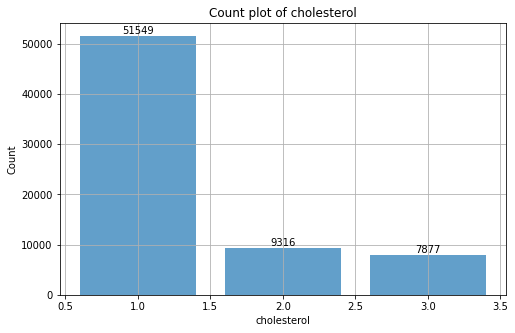

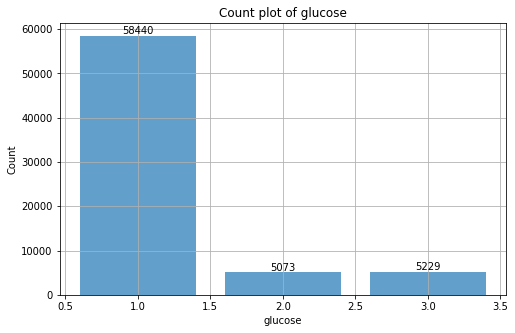

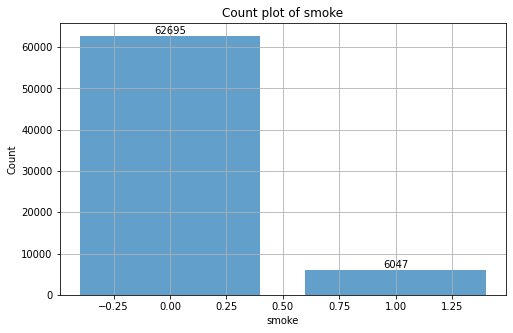

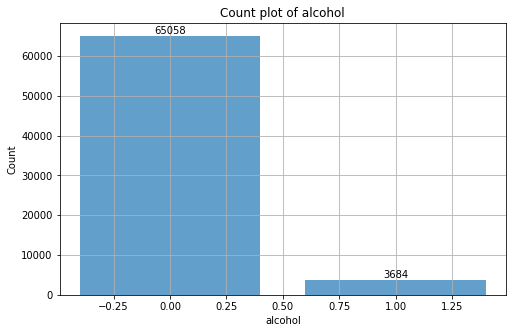

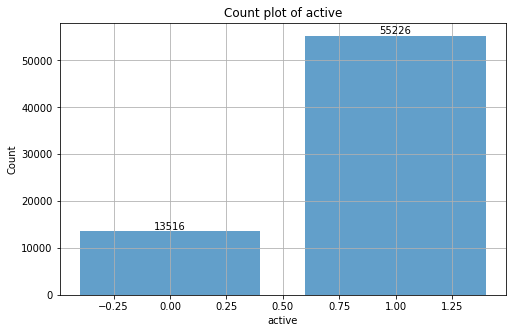

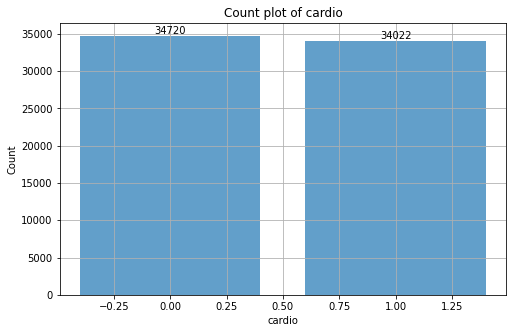

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("Visualization").getOrCreate()

# Load the dataset
data = spark.read.csv('output_data3.3.csv', header=True, inferSchema=True)

# Visualization for continuous variables
continuous_vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']

for column in continuous_vars:
    # Collect the column data from Spark to the driver (as a list)
    col_data = data.select(column).rdd.flatMap(lambda x: x).collect()
    
    plt.figure(figsize=(12,6))
    plt.hist(col_data, bins=50, density=True, alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# Visualization for categorical variables
categorical_vars = ['gender', 'cholesterol', 'glucose', 'smoke', 'alcohol', 'active', 'cardio']

for column in categorical_vars:
    # Get the count for each category
    cat_count = data.groupBy(column).count().sort(column).collect()
    
    categories = [row[column] for row in cat_count]
    counts = [row['count'] for row in cat_count]
    
    plt.figure(figsize=(8,5))
    ax = plt.bar(categories, counts, alpha=0.7)
    
    # Display count on top of bars
    for idx, rect in enumerate(ax):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height, '%d' % int(height),
                 ha='center', va='bottom')
    
    plt.title(f'Count plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


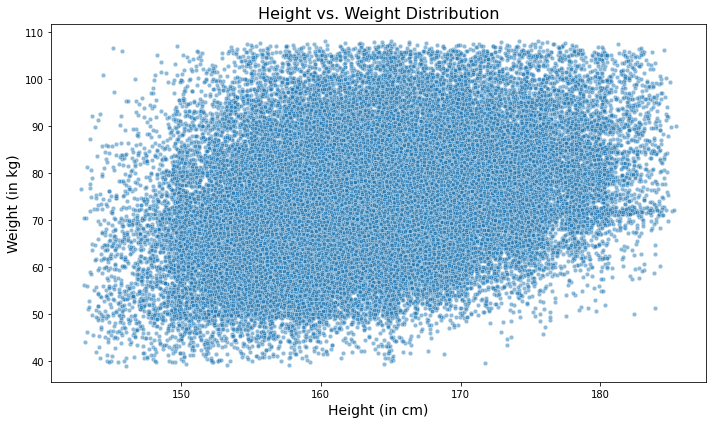

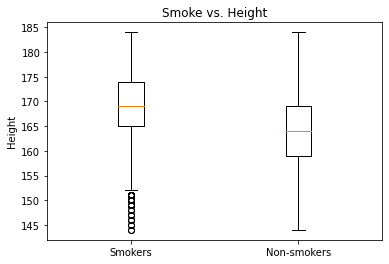

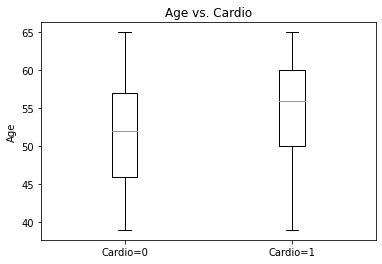

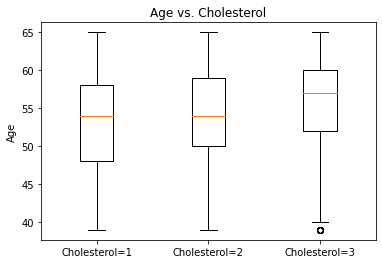

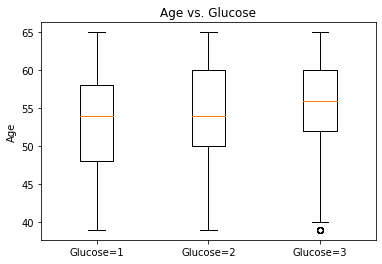

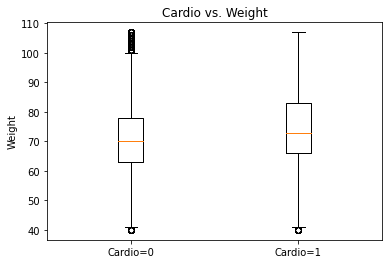

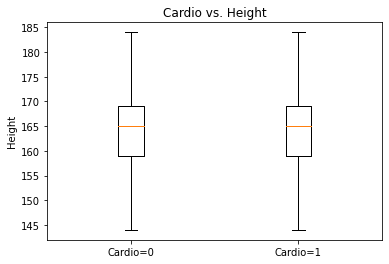

In [3]:

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder \
    .appName("DataVisualization") \
    .getOrCreate()

# Load the data
data_path = 'output_data3.3.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)






# Extract height and weight data
height_data = df.select("height").rdd.flatMap(lambda x: x).collect()
weight_data = df.select("weight").rdd.flatMap(lambda x: x).collect()

# Jittering the data
height_jitter = np.array(height_data) + np.random.normal(0, 0.5, size=len(height_data))
weight_jitter = np.array(weight_data) + np.random.normal(0, 0.5, size=len(weight_data))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(height_jitter, weight_jitter, alpha=0.5, s=20, edgecolors="w", linewidth=0.5)

# Setting the labels and title
plt.xlabel("Height (in cm)", fontsize=14)
plt.ylabel("Weight (in kg)", fontsize=14)
plt.title("Height vs. Weight Distribution", fontsize=16)
plt.tight_layout()
plt.show()


from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Boxplot Analysis") \
    .getOrCreate()

smokers = df.filter(df["smoke"] == 1).select("height").rdd.flatMap(lambda x: x).collect()
non_smokers = df.filter(df["smoke"] == 0).select("height").rdd.flatMap(lambda x: x).collect()

plt.boxplot([smokers, non_smokers], labels=['Smokers', 'Non-smokers'])
plt.title("Smoke vs. Height")
plt.ylabel("Height")
plt.show()

#Age vs. Cardio:
cardio_0 = df.filter(df["cardio"] == 0).select("age").rdd.flatMap(lambda x: x).collect()
cardio_1 = df.filter(df["cardio"] == 1).select("age").rdd.flatMap(lambda x: x).collect()

plt.boxplot([cardio_0, cardio_1], labels=['Cardio=0', 'Cardio=1'])
plt.title("Age vs. Cardio")
plt.ylabel("Age")
plt.show()

#Age vs. cholesterol:
cholesterol_1 = df.filter(df["cholesterol"] == 1).select("age").rdd.flatMap(lambda x: x).collect()
cholesterol_2 = df.filter(df["cholesterol"] == 2).select("age").rdd.flatMap(lambda x: x).collect()
cholesterol_3 = df.filter(df["cholesterol"] == 3).select("age").rdd.flatMap(lambda x: x).collect()

plt.boxplot([cholesterol_1, cholesterol_2, cholesterol_3], labels=['Cholesterol=1', 'Cholesterol=2', 'Cholesterol=3'])
plt.title("Age vs. Cholesterol")
plt.ylabel("Age")
plt.show()

#Age vs. Glucose:
glucose_1 = df.filter(df["glucose"] == 1).select("age").rdd.flatMap(lambda x: x).collect()
glucose_2 = df.filter(df["glucose"] == 2).select("age").rdd.flatMap(lambda x: x).collect()
glucose_3 = df.filter(df["glucose"] == 3).select("age").rdd.flatMap(lambda x: x).collect()

plt.boxplot([glucose_1, glucose_2, glucose_3], labels=['Glucose=1', 'Glucose=2', 'Glucose=3'])
plt.title("Age vs. Glucose")
plt.ylabel("Age")
plt.show()

#Cardio vs. Weight:
cardio_0_weight = df.filter(df["cardio"] == 0).select("weight").rdd.flatMap(lambda x: x).collect()
cardio_1_weight = df.filter(df["cardio"] == 1).select("weight").rdd.flatMap(lambda x: x).collect()

plt.boxplot([cardio_0_weight, cardio_1_weight], labels=['Cardio=0', 'Cardio=1'])
plt.title("Cardio vs. Weight")
plt.ylabel("Weight")
plt.show()

#Cardio vs. Height:
cardio_0_height = df.filter(df["cardio"] == 0).select("height").rdd.flatMap(lambda x: x).collect()
cardio_1_height = df.filter(df["cardio"] == 1).select("height").rdd.flatMap(lambda x: x).collect()

plt.boxplot([cardio_0_height, cardio_1_height], labels=['Cardio=0', 'Cardio=1'])
plt.title("Cardio vs. Height")
plt.ylabel("Height")
plt.show()

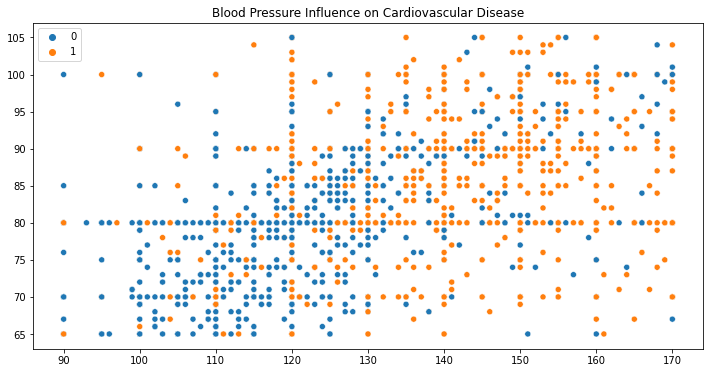

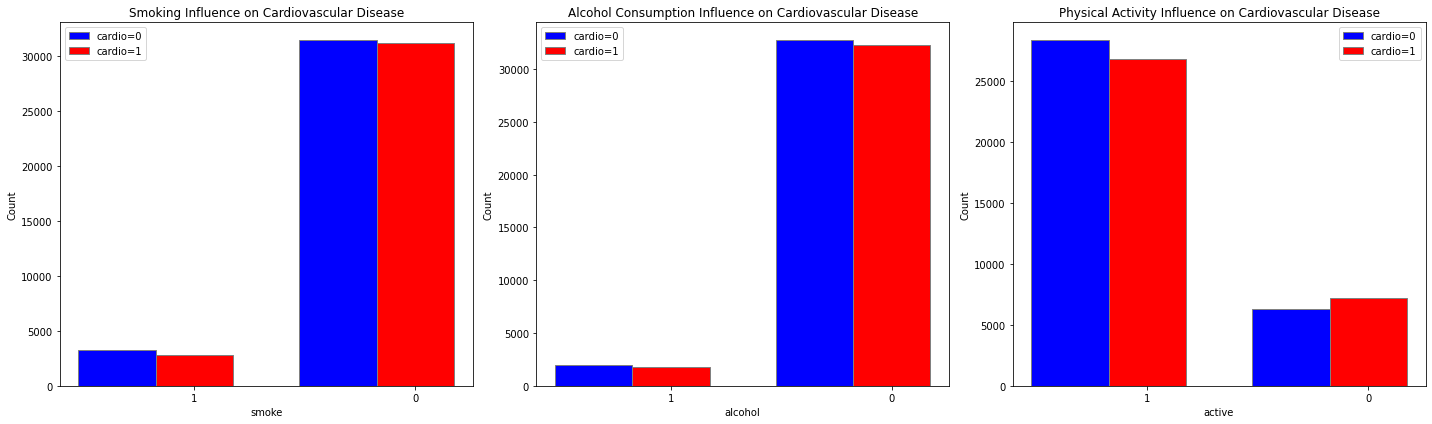

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Blood Pressure vs Cardiovascular Disease
ap_hi = df.select("ap_hi").rdd.flatMap(lambda x: x).collect()
ap_lo = df.select("ap_lo").rdd.flatMap(lambda x: x).collect()
cardio = df.select("cardio").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12,6))
sns.scatterplot(x=ap_hi, y=ap_lo, hue=cardio)
plt.title('Blood Pressure Influence on Cardiovascular Disease')
plt.show()

# Set up the plotting layout
f, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define a function to draw the bar plots
def draw_barplot(column_name, ax_index, title):
    data = df.groupBy(column_name, "cardio").count().collect()
    data_dict = {(row[column_name], row["cardio"]): row["count"] for row in data}
    unique_vals = df.select(column_name).distinct().rdd.flatMap(lambda x: x).collect()
    counts_0 = [data_dict.get((val, 0), 0) for val in unique_vals]
    counts_1 = [data_dict.get((val, 1), 0) for val in unique_vals]
    
    bar_width = 0.35
    r1 = np.arange(len(unique_vals))
    r2 = [x + bar_width for x in r1]
    
    axes[ax_index].bar(r1, counts_0, color='b', width=bar_width, edgecolor='grey', label='cardio=0')
    axes[ax_index].bar(r2, counts_1, color='r', width=bar_width, edgecolor='grey', label='cardio=1')
    
    axes[ax_index].set_title(title)
    axes[ax_index].set_xticks([r + bar_width for r in range(len(unique_vals))])
    axes[ax_index].set_xticklabels(unique_vals)
    axes[ax_index].set_ylabel('Count')
    axes[ax_index].set_xlabel(column_name)
    axes[ax_index].legend()

# Drawing the bar plots
draw_barplot("smoke", 0, 'Smoking Influence on Cardiovascular Disease')
draw_barplot("alcohol", 1, 'Alcohol Consumption Influence on Cardiovascular Disease')
draw_barplot("active", 2, 'Physical Activity Influence on Cardiovascular Disease')

plt.tight_layout()
plt.show()
